In [17]:
!export CUDA_VISIBLE_DEVICES=1,2,3,4,5,6

In [18]:
import copy

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn import metrics
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

START_TOKEN = "<START>"
STOP_TOKEN = "<STOP>"
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"

SPECIAL_TOKENS = [START_TOKEN, STOP_TOKEN, PAD_TOKEN]


train_df = pd.read_csv("hw_3_train_data.csv")

In [19]:
def get_free_gpu():
    available_mem = []
    for i in range(6):
        t = torch.cuda.get_device_properties(i).total_memory
        r = torch.cuda.memory_reserved(i)
        a = torch.cuda.memory_allocated(i)
        available_mem.append(t - r)

    return int(np.argmax(available_mem))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")
if torch.cuda.is_available():
    free_gpu_id = get_free_gpu()
    torch.cuda.set_device(free_gpu_id)

using cuda


In [20]:
def tokenize(corpus, callback=lambda sent: sent.split()):
    return [callback(sent) for sent in corpus]


def add_start_stop_tokens(corpus):
    return [[START_TOKEN] + sent + [STOP_TOKEN] for sent in corpus]


def padding(corpus, seq_len):
    for sent in corpus:
        while len(sent) < seq_len:
            sent.append(PAD_TOKEN)
        while len(sent) > seq_len:
            sent.pop()
    return corpus


def build_vocab(corpus):
    vocab = set()
    for sent in corpus:
        vocab.update(set(sent))
    vocab = list(vocab) + [UNK_TOKEN]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for idx, word in enumerate(vocab)}
    return vocab, word2idx, idx2word


def convert_to_idx(corpus, word2idx):
    return [[word2idx.get(word, "<UNK>") for word in sent] for sent in corpus]

In [21]:
# Data Preprocessing
# Create Dataset class
class UtteranceSlotDataset(Dataset):
    def __init__(self, utterances, slots, seq_len=None):
        # tokenization
        utterances = tokenize(utterances)
        slots = tokenize(slots)

        # adding start and stop tokens
        utterances = add_start_stop_tokens(utterances)
        slots = add_start_stop_tokens(slots)

        self.unpad_utterances = copy.deepcopy(utterances)
        self.unpad_slots = copy.deepcopy(slots)

        # padding
        self.seq_len = seq_len
        if not seq_len:
            self.seq_len = len(max(utterances, key=lambda sent: len(sent)))
        utterances = padding(utterances, self.seq_len)
        slots = padding(slots, self.seq_len)

        # get vocab for both utterance and slot
        self.vocab, self.word2idx, self.idx2word = build_vocab(utterances)
        self.slot_list, self.slot2idx, self.idx2slot = build_vocab(slots)

        # convert to index space
        utterances = convert_to_idx(utterances, self.word2idx)
        slots = convert_to_idx(slots, self.slot2idx)

        # Convert arrays to torch tensors
        self.X = torch.tensor(utterances).to(device)
        self.y = torch.tensor(slots).to(device)

    # Must have
    def __len__(self):
        return len(self.y)

    # Must have
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [22]:
# functions for creating the embedding layer


def get_one_hot_matrix(vocab):
    one_hot_matrix = np.zeros((len(vocab), len(vocab)))
    np.fill_diagonal(one_hot_matrix, 1)
    return one_hot_matrix


def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({"weight": torch.tensor(weights_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [23]:
from models import BaselineModel, RNNTwoLayerModel


class GRUModel(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        seq_len,
        emb_layer,
    ):
        super(GRUModel, self).__init__()
        # Defining some parameters
        self.input_size = input_size
        self.output_size = output_size
        self.seq_len = seq_len

        # Defining the layers
        # Embedding Layer
        self.emb_layer = emb_layer
        # RNN Layer
        self.rnn = nn.GRUCell(input_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        out = self.emb_layer(x)

        hiddens = []

        # Initializing hidden state for first input
        hidden = torch.zeros(batch_size, self.output_size).to(device)

        for t in range(self.seq_len):
            hidden = self.rnn(out[:, t, :], hidden)
            # make an additional dimension
            hiddens.append(torch.unsqueeze(hidden, dim=2))

        # concat all the hidden layer
        hiddens = torch.cat(hiddens, dim=2)
        out = F.softmax(hiddens, dim=1)
        return out


class LSTMModel(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        seq_len,
        emb_layer,
    ):
        super(LSTMModel, self).__init__()
        # Defining some parameters
        self.input_size = input_size
        self.output_size = output_size
        self.seq_len = seq_len

        # Defining the layers
        # Embedding Layer
        self.emb_layer = emb_layer
        # RNN Layer
        self.rnn = nn.LSTMCell(input_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        out = self.emb_layer(x)

        hiddens = []

        # Initializing hidden state for first input
        hidden = torch.zeros(batch_size, self.output_size).to(device)
        cell = torch.zeros(batch_size, self.output_size).to(device)

        for t in range(self.seq_len):
            hidden, cell = self.rnn(out[:, t, :], (hidden, cell))
            # make an additional dimension
            hiddens.append(torch.unsqueeze(hidden, dim=2))

        # concat all the hidden layer
        hiddens = torch.cat(hiddens, dim=2)
        out = F.softmax(hiddens, dim=1)
        return out

In [24]:
# Evaluation
def evaluate(true, pred, output_dict=False):
    gold = [slot for sequence in true for slot in sequence]
    pred = [slot for sequence in pred for slot in sequence]
    return metrics.classification_report(
        gold, pred, output_dict=output_dict, zero_division=0
    )


def inference(model, val_X):
    val_pred = model(val_X)
    val_pred = torch.argmax(val_pred, dim=1)
    return val_pred


def val_accuracy(model, val_set, utterance_slot_dataset):

    val_X = utterance_slot_dataset.X[val_set.indices]
    val_y = utterance_slot_dataset.y[val_set.indices]
    val_pred = inference(model, val_X)

    input_seqs = [
        utterance_slot_dataset.unpad_utterances[indice]
        for indice in val_set.indices
    ]
    trues = [
        utterance_slot_dataset.unpad_slots[indice]
        for indice in val_set.indices
    ]
    preds = convert_to_token(
        val_pred.tolist(), utterance_slot_dataset.idx2slot
    )

    input_seqs, preds, trues = process_output_corpus(input_seqs, preds, trues)

    return evaluate(trues, preds, output_dict=True)["accuracy"]

In [25]:
train_utterances = list(train_df["utterances"])
train_slots = list(train_df["IOB Slot tags"])
utterance_slot_dataset = UtteranceSlotDataset(
    train_utterances,
    train_slots,
    seq_len=int(np.max([len(sent.split()) for sent in train_utterances])) + 10,
)
val_len = int(len(utterance_slot_dataset) * 0.3)
train_set, val_set = random_split(
    utterance_slot_dataset, [len(utterance_slot_dataset) - val_len, val_len]
)

In [26]:
# Define hyperparameters

## Model
num_classes = len(utterance_slot_dataset.slot2idx)
seq_len = utterance_slot_dataset.seq_len

## Training
batch_size = 2048


train_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
)

all_train_loader = DataLoader(
    dataset=utterance_slot_dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [27]:
from train import train

10/500:	batch loss:  3.3545045852661133	train loss:  3.3459692001342773	val loss:  3.3464224338531494	train accuracy:  0.8273374085579718	val accuracy:  0.8046688899475941
20/500:	batch loss:  3.2898685932159424	train loss:  3.286773204803467	val loss:  3.288118362426758	train accuracy:  0.8556969636236096	val accuracy:  0.8141972367794188
30/500:	batch loss:  3.279932737350464	train loss:  3.279777765274048	val loss:  3.2814841270446777	train accuracy:  0.889267461669506	val accuracy:  0.8311100524059076
40/500:	batch loss:  3.2788357734680176	train loss:  3.278769016265869	val loss:  3.2808117866516113	train accuracy:  0.9076059725423389	val accuracy:  0.8387327298713673
50/500:	batch loss:  3.27821946144104	train loss:  3.2781474590301514	val loss:  3.2802276611328125	train accuracy:  0.926345325182884	val accuracy:  0.8585040495474036
60/500:	batch loss:  3.277559518814087	train loss:  3.2775354385375977	val loss:  3.279668092727661	train accuracy:  0.9329592143501353	val accuracy:

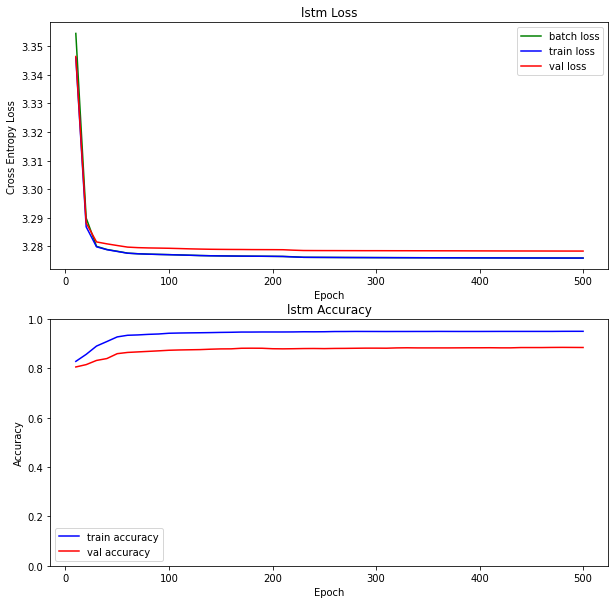

In [28]:
# create the embedding layer
one_hot_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_one_hot_matrix(utterance_slot_dataset.vocab)
)

lstm_model = LSTMModel(
    input_size=embedding_dim,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=one_hot_emb_layer,
).to(device)
train(
    model=lstm_model,
    n_epochs=500,
    data_loader=train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(lstm_model.parameters(), lr=0.005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
    plot_name="lstm",
)

10/500:	batch loss:  3.2981414794921875	train loss:  3.291905164718628	val loss:  3.292855739593506	train accuracy:  0.7125964525503558	val accuracy:  0.6815150071462601
20/500:	batch loss:  3.2770302295684814	train loss:  3.276329517364502	val loss:  3.278026819229126	train accuracy:  0.9266459565086682	val accuracy:  0.8730347784659361
30/500:	batch loss:  3.2743844985961914	train loss:  3.2741928100585938	val loss:  3.2761476039886475	train accuracy:  0.9259444834151719	val accuracy:  0.8689852310624107
40/500:	batch loss:  3.2723498344421387	train loss:  3.272203207015991	val loss:  3.2743301391601562	train accuracy:  0.926345325182884	val accuracy:  0.8677941877084326
50/500:	batch loss:  3.271690607070923	train loss:  3.271681785583496	val loss:  3.273836612701416	train accuracy:  0.9329592143501353	val accuracy:  0.8742258218199143
60/500:	batch loss:  3.271613597869873	train loss:  3.2716095447540283	val loss:  3.273759365081787	train accuracy:  0.9361659484918329	val accuracy:

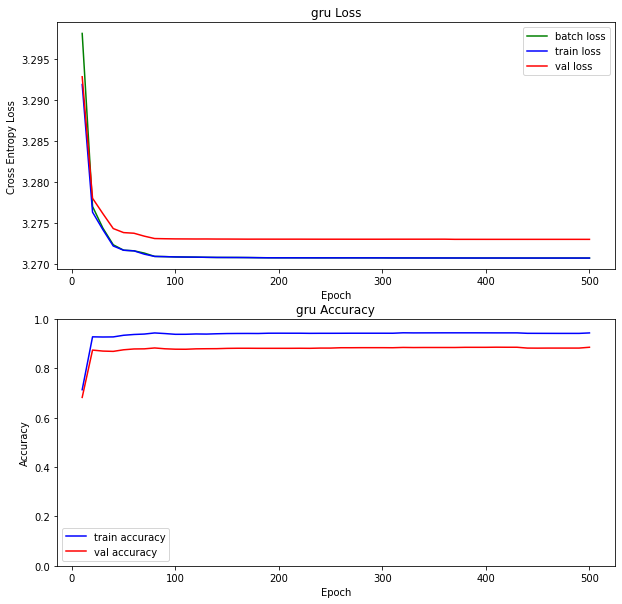

In [29]:
# create the embedding layer
one_hot_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_one_hot_matrix(utterance_slot_dataset.vocab)
)

gru_model = GRUModel(
    input_size=embedding_dim,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=one_hot_emb_layer,
).to(device)
train(
    model=gru_model,
    n_epochs=500,
    data_loader=train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(gru_model.parameters(), lr=0.005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
    plot_name='gru'
)

10/500:	batch loss:  3.3408775329589844	train loss:  3.3302698135375977	val loss:  3.3307366371154785	train accuracy:  0.7959715402344925	val accuracy:  0.7472606002858504
20/500:	batch loss:  3.286041736602783	train loss:  3.2849645614624023	val loss:  3.2859127521514893	train accuracy:  0.8350536125864315	val accuracy:  0.7696522153406384
30/500:	batch loss:  3.2797296047210693	train loss:  3.2791695594787598	val loss:  3.2803125381469727	train accuracy:  0.9013929251427999	val accuracy:  0.8556455454978561
40/500:	batch loss:  3.275592565536499	train loss:  3.275423288345337	val loss:  3.2767279148101807	train accuracy:  0.9124160737548852	val accuracy:  0.8763696998570748
50/500:	batch loss:  3.274116277694702	train loss:  3.2740206718444824	val loss:  3.2754554748535156	train accuracy:  0.9211343822026256	val accuracy:  0.8804192472606003
60/500:	batch loss:  3.273219347000122	train loss:  3.273139476776123	val loss:  3.2746663093566895	train accuracy:  0.928249323579517	val accur

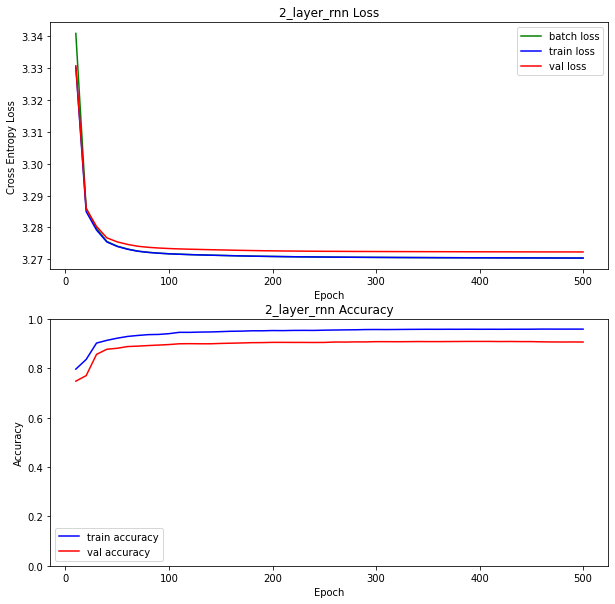

In [32]:
# create the embedding layer
one_hot_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_one_hot_matrix(utterance_slot_dataset.vocab)
)

rnn_model = RNNTwoLayerModel(
    input_size=embedding_dim,
    hidden_size=32,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=one_hot_emb_layer,
).to(device)
train(
    model=rnn_model,
    n_epochs=500,
    data_loader=train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(rnn_model.parameters(), lr=0.005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
    plot_name='2_layer_rnn',
)

10/500:	batch loss:  3.3087522983551025	train loss:  3.2970407009124756	val loss:  3.298107147216797	train accuracy:  0.928349534021445	val accuracy:  0.8716055264411624
20/500:	batch loss:  3.2728257179260254	train loss:  3.2724721431732178	val loss:  3.274329423904419	train accuracy:  0.9228379597154024	val accuracy:  0.8673177703668413
30/500:	batch loss:  3.2712018489837646	train loss:  3.27119517326355	val loss:  3.2731451988220215	train accuracy:  0.919931856899489	val accuracy:  0.8632682229633158
40/500:	batch loss:  3.2710824012756348	train loss:  3.2710697650909424	val loss:  3.2730369567871094	train accuracy:  0.9214350135284096	val accuracy:  0.8646974749880896
50/500:	batch loss:  3.27101993560791	train loss:  3.2710165977478027	val loss:  3.2729830741882324	train accuracy:  0.9206333299929853	val accuracy:  0.8635064316341114
60/500:	batch loss:  3.2709872722625732	train loss:  3.270986557006836	val loss:  3.2729527950286865	train accuracy:  0.9205331195510572	val accurac

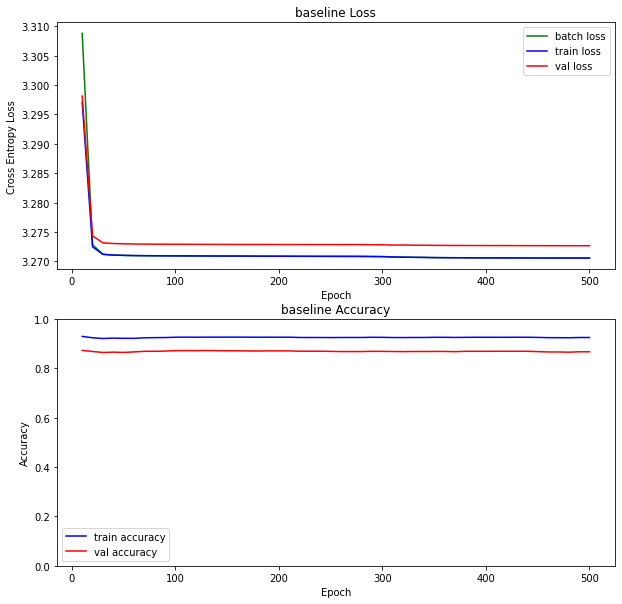

In [33]:
# create the embedding layer
one_hot_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_one_hot_matrix(utterance_slot_dataset.vocab)
)

val_model = BaselineModel(
    input_size=embedding_dim,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=one_hot_emb_layer,
).to(device)
train(
    model=val_model,
    n_epochs=500,
    data_loader=train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(val_model.parameters(), lr=0.005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
    plot_name='baseline'
)

10/500:	val accuracy:  0.7080432172869148	loss:  3.426575183868408
20/500:	val accuracy:  0.7258103241296519	loss:  3.4212117195129395
30/500:	val accuracy:  0.7267707082833134	loss:  3.4151108264923096
40/500:	val accuracy:  0.7267707082833134	loss:  3.4084339141845703
50/500:	val accuracy:  0.7267707082833134	loss:  3.4017345905303955
60/500:	val accuracy:  0.7267707082833134	loss:  3.395993232727051
70/500:	val accuracy:  0.7270108043217287	loss:  3.3908004760742188
80/500:	val accuracy:  0.7272509003601441	loss:  3.386258363723755
90/500:	val accuracy:  0.7277310924369748	loss:  3.3822789192199707
100/500:	val accuracy:  0.7294117647058823	loss:  3.378302574157715
110/500:	val accuracy:  0.731812725090036	loss:  3.374307870864868
120/500:	val accuracy:  0.7349339735894358	loss:  3.369905471801758
130/500:	val accuracy:  0.7414165666266507	loss:  3.365508556365967
140/500:	val accuracy:  0.7418967587034814	loss:  3.360661506652832
150/500:	val accuracy:  0.7414165666266507	loss:  3.

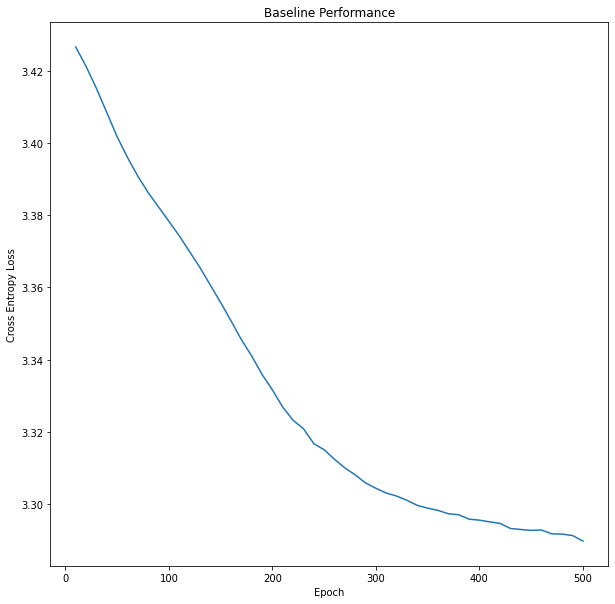

In [223]:
# create the embedding layer
one_hot_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_one_hot_matrix(utterance_slot_dataset.vocab)
)

test_model = RNNModel(
    input_size=embedding_dim,
    hidden_size=32,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=one_hot_emb_layer,
).to(device)

10/500:	val accuracy:  0.9159663865546218	loss:  3.2751166820526123
20/500:	val accuracy:  0.9164465786314526	loss:  3.274977207183838
30/500:	val accuracy:  0.9171668667466987	loss:  3.2749581336975098
40/500:	val accuracy:  0.9190876350540216	loss:  3.2748756408691406
50/500:	val accuracy:  0.9195678271308524	loss:  3.2742817401885986
60/500:	val accuracy:  0.92124849939976	loss:  3.274354934692383
70/500:	val accuracy:  0.92124849939976	loss:  3.2740511894226074
80/500:	val accuracy:  0.921968787515006	loss:  3.2741012573242188
90/500:	val accuracy:  0.9231692677070829	loss:  3.2744081020355225
100/500:	val accuracy:  0.9250900360144058	loss:  3.273909330368042
110/500:	val accuracy:  0.9253301320528211	loss:  3.2740867137908936
120/500:	val accuracy:  0.9255702280912365	loss:  3.273796558380127
130/500:	val accuracy:  0.9260504201680673	loss:  3.2736318111419678
140/500:	val accuracy:  0.9262905162064826	loss:  3.2735233306884766
150/500:	val accuracy:  0.9270108043217287	loss:  3.

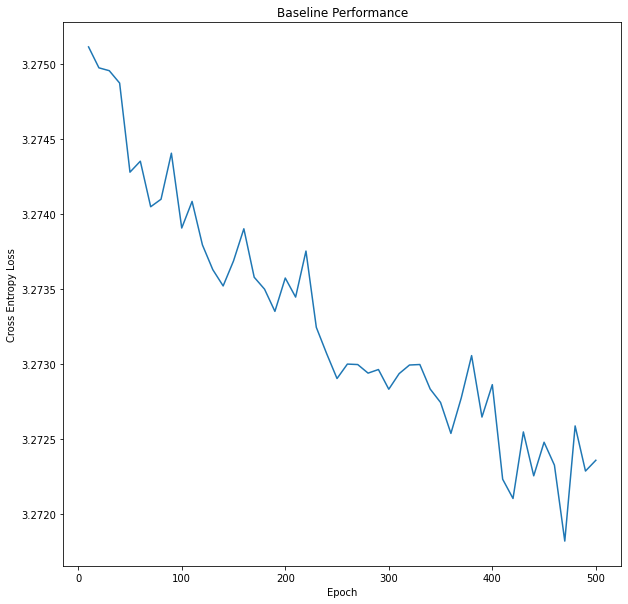

In [225]:
train(
    model=test_model,
    n_epochs=500,
    data_loader=all_train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(test_model.parameters(), lr=0.00005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
)

In [227]:
# Output Processing
def process_output_corpus(input_seqs, preds, trues):
    new_seqs = []
    new_preds = []
    new_trues = []
    for i in range(len(input_seqs)):
        new_seq, new_pred, new_true = remove_special_tokens(
            input_seqs[i], preds[i], trues[i]
        )
        new_seqs.append(new_seq)
        new_preds.append(new_pred)
        new_trues.append(new_true)
    return new_seqs, new_preds, new_trues


def remove_special_tokens(input_seq, pred, true):
    new_seq = []
    new_pred = []
    new_true = []
    new_seq = input_seq[1:-1]
    new_true = true[1:-1]
    new_pred = pred[1:]

    # if is truncated padding
    while len(new_pred) < len(new_seq):
        new_pred.append(PAD_TOKEN)

    # if is expanded padding
    while len(new_pred) > len(new_seq):
        new_pred = new_pred[:-1]

    return new_seq, new_pred, new_true


def convert_to_token(corpus, idx2token):
    return [[idx2token[token_idx] for token_idx in sent] for sent in corpus]


def preprocess_utterances(utterances, utterance_dataset):
    # tokenization
    utterances = tokenize(utterances)
    # add special tokens
    utterances = add_start_stop_tokens(utterances)
    tokenized_utterances = copy.deepcopy(utterances)
    # padding
    utterances = padding(utterances, utterance_dataset.seq_len)

    word2idx = utterance_dataset.word2idx
    utterances = [
        [word2idx.get(token, word2idx[UNK_TOKEN]) for token in sent]
        for sent in utterances
    ]

    return utterances, tokenized_utterances

In [228]:
test_df = pd.read_csv("test_data.csv")
test_utterances = list(test_df["utterances"])
test_input, test_input_seqs = preprocess_utterances(
    test_utterances, utterance_slot_dataset
)
test_X = torch.tensor(test_input).to(device)

In [229]:
test_pred = inference(test_model, test_X)

In [230]:
# input_seqs = convert_to_token(test_X.tolist(), utterance_slot_dataset.idx2word)
preds = convert_to_token(test_pred.tolist(), utterance_slot_dataset.idx2slot)
test_input_seqs, preds, _ = process_output_corpus(
    test_input_seqs, preds, preds
)

In [231]:
len([slot for seq in preds for slot in seq])

6415

In [233]:
for i, sent in enumerate(test_input_seqs):
    if len(sent) != len(test_utterances[i].split()):
        print(sent, test_utterances[i])

In [234]:
for pred in preds:
    for i, slot in enumerate(pred):
        if slot in SPECIAL_TOKENS:
            pred[i] = "O"

In [235]:
all_slots = [slot for seq in preds for slot in seq]

In [236]:
len(all_slots)

6415

In [237]:
indexes = list(range(len(all_slots)))

In [238]:
output_df = pd.DataFrame({"Id": indexes, "Predicted": all_slots})

In [239]:
output_df.to_csv("2_layer_rnn.csv", index=False)